In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Wybór zbioru danych

Wybrałem zbiór <a href='https://www.openml.org/d/198'/>delta_elevators</a>.

In [51]:
data = pd.read_csv('dataset_2202_elevators.csv')
X = data.loc[:,data.columns != 'Goal']
y = data['Goal']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [52]:
# XGBoost model
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
mse_xgb = mean_squared_error(y_test, model_xgb.predict(X_test))
print("MSE of XGB model: " + str(mse_xgb))

MSE of XGB model: 2.0506746987951803e-05


In [55]:
# Random Forest model
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
mse_rf = mean_squared_error(y_test, model_rf.predict(X_test))
print("MSE of RF model: " + str(mse_rf))

MSE of RF model: 8.157941918640627e-06


In [56]:
# Linear Regression model
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
mse_linear = mean_squared_error(y_test, model_linear.predict(X_test))
print("MSE of linear model: " + str(mse_linear))

MSE of linear model: 8.205070721249685e-06


## Wykresy PDP dla poszczególnych zmiennych

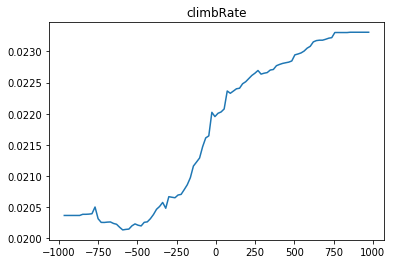

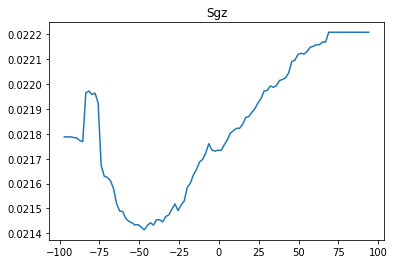

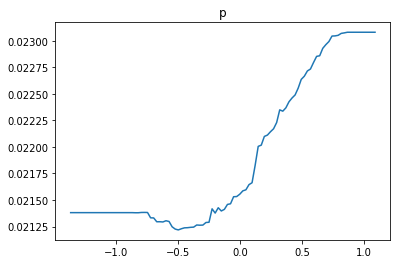

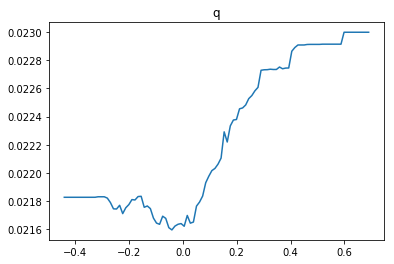

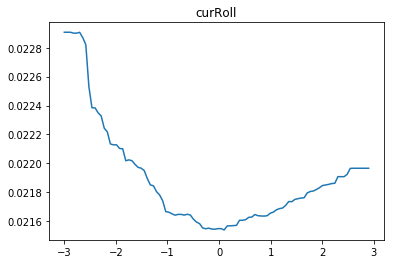

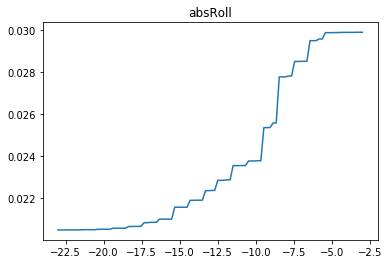

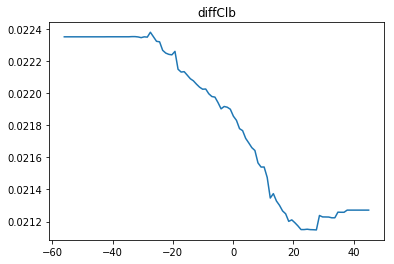

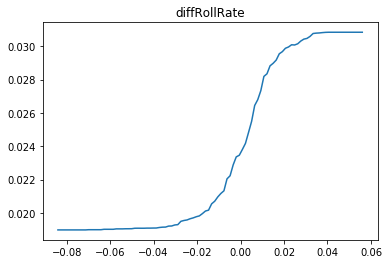

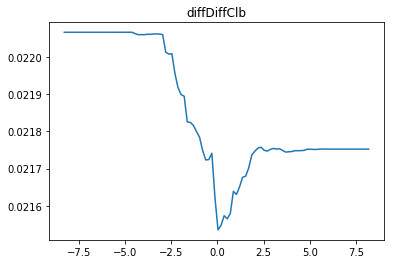

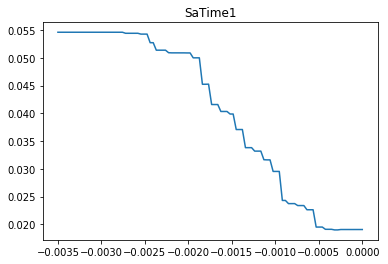

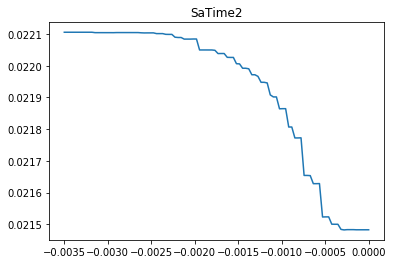

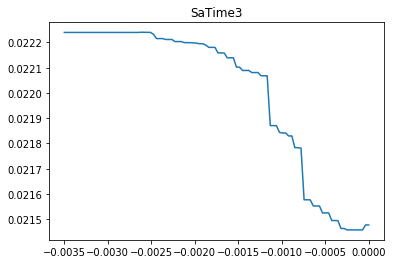

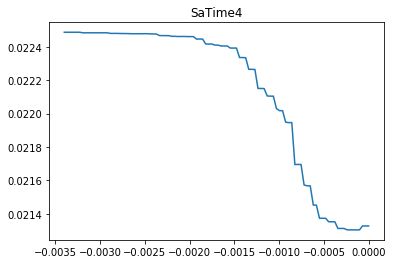

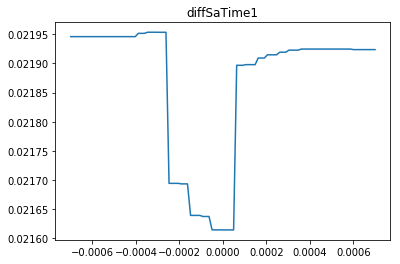

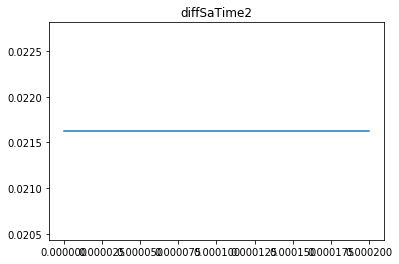

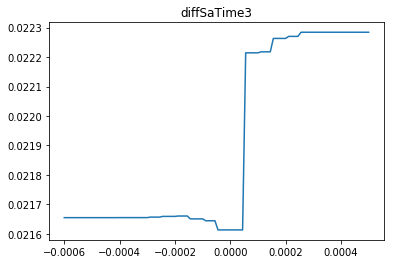

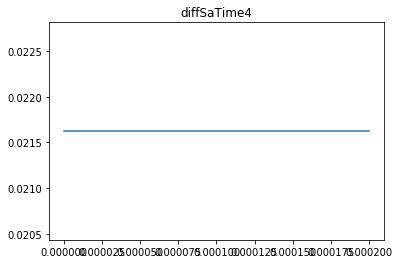

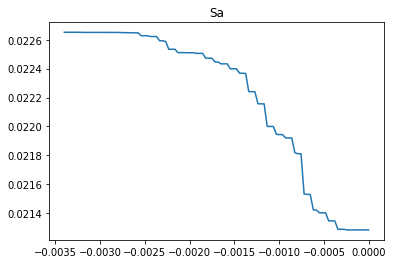

In [57]:
import matplotlib.pyplot as plt

# PDP plots
N_POINTS = 100

def get_pd(model, X, feature_name):
    xs = np.linspace(X[feature_name].min(), X[feature_name].max(), N_POINTS)
    ys = []
    for x in xs:
        X[feature_name] = x
        predictions = model.predict(X)
        avg = sum(predictions)/len(predictions)
        ys.append(avg)
    return xs, ys

plots = []
for feature_name in X_train.columns:
    xs, ys = get_pd(model_rf, X_train.copy(), feature_name)
    plots.append((xs, ys))
    fig, axes = plt.subplots()
    axes.plot(xs, ys)
    axes.set_title(feature_name)
    fig.show()

## Wykresy PDP z zaznacznymi punktami podziału dla poszczególnych zmiennych

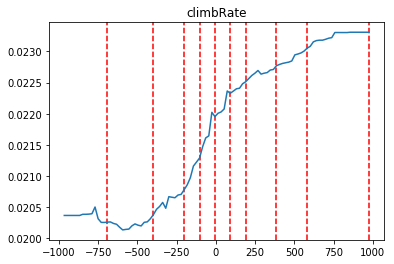

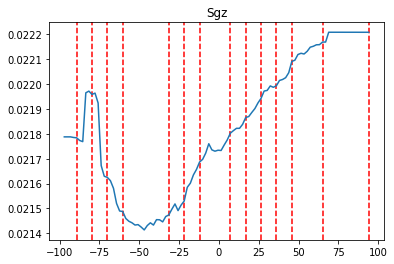

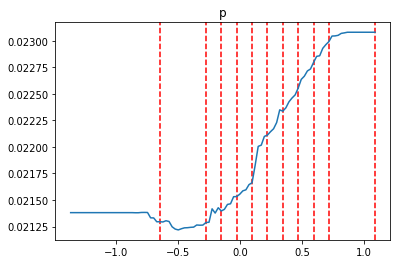

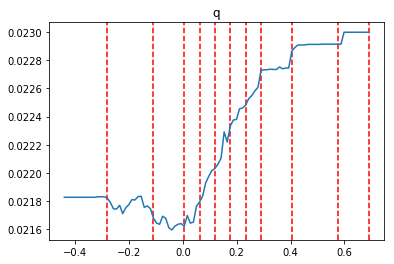

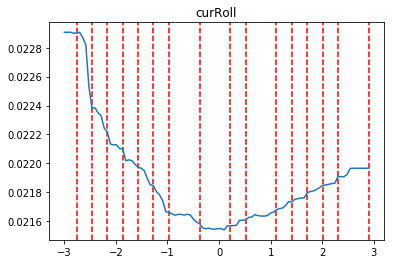

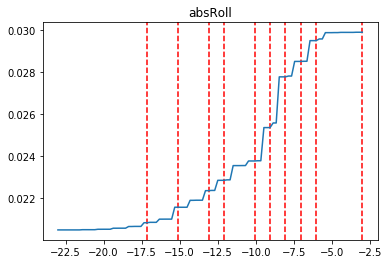

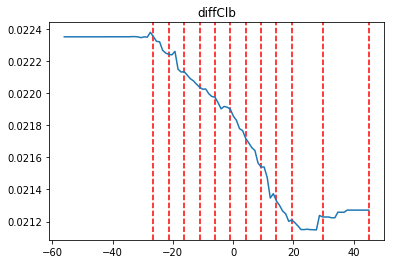

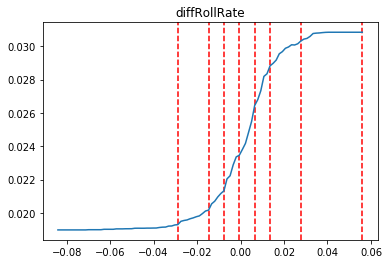

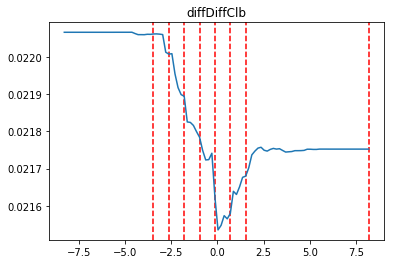

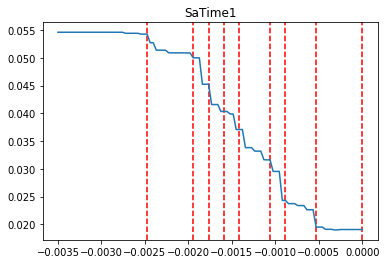

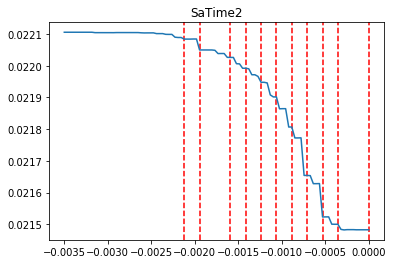

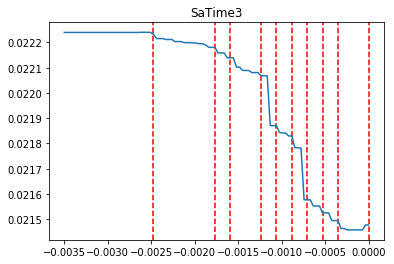

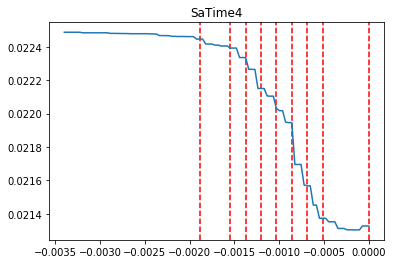

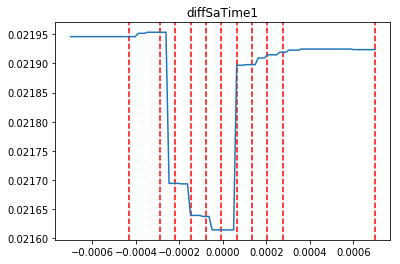

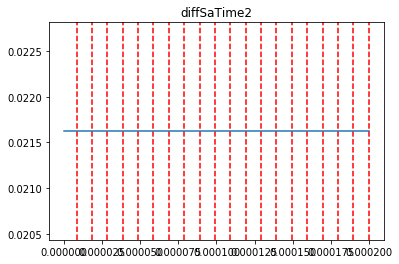

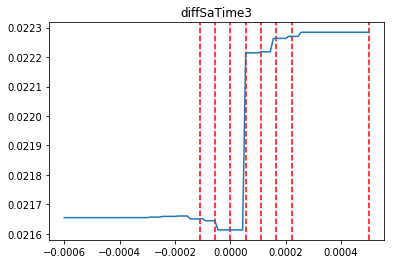

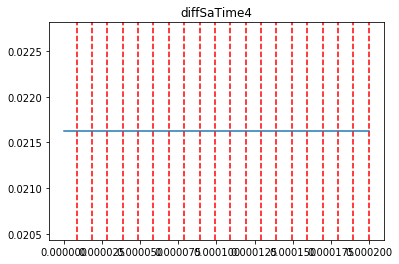

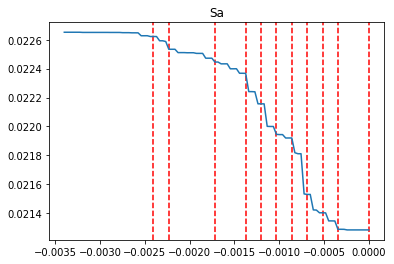

In [102]:
import ruptures as rpt

def get_divisions(plots, column_names, plot = True):
    divisions = []
    for i in range(len(plots)):
        res = rpt.Pelt(model="rbf").fit_predict(np.array(plots[i][1]), pen=0.1)
        
        breaks = []
        
        for brk in res:
            breaks.append(plots[i][0][brk-1])
        
        divisions.append(breaks)
        
        if plot:
            fig, axes = plt.subplots()
            for brk in res:
                axes.axvline(x=plots[i][0][brk-1], linestyle='--', color='r')
            axes.plot(plots[i][0], plots[i][1])
            axes.set_title(column_names[i])
            fig.show()
            
    return divisions
            
divisions = get_divisions(plots, X_train.columns)

## Dane z zamienionymi wartościami

In [103]:
def convert_value(value, divisions):
    if value < divisions[0]:
        return divisions[0]
    for i in range(len(divisions)):
        if value < divisions[i]:
            return (divisions[i]+divisions[i-1])*0.5
    return divisions[-1]

def change_dataset(X, divisions):
    for i in range(len(X.columns)):
        column = X.columns[i]
        breaks = divisions[i]
        X[column] = X[column].apply(lambda val: convert_value(val, breaks))
    return X


X_train_converted = change_dataset(X_train.copy(), divisions)
X_test_converted = change_dataset(X_test.copy(), divisions)

## Modele XGB i liniowy wytrenowane na zmienionych danych

In [104]:
model_xgb_converted = XGBClassifier().fit(X_train_converted, y_train)
mse_xgb_converted = mean_squared_error(y_test, model_xgb_converted.predict(X_test_converted))

In [105]:
model_rf_converted = RandomForestRegressor().fit(X_train_converted, y_train)
mse_rf_converted = mean_squared_error(y_test, model_rf_converted.predict(X_test_converted))

In [106]:
model_linear_converted = LinearRegression().fit(X_train_converted, y_train)
mse_linear_converted = mean_squared_error(y_test, model_linear_converted.predict(X_test_converted))

In [107]:
mse = [mse_xgb, mse_rf, mse_linear]
mse_converted = [mse_xgb_converted, mse_rf_converted, mse_linear_converted]
model_names = ["XGB", "Random Forest", "Regresja liniowa"]

for i in range(len(mse)):
    print("Model " + model_names[i] + ":")
    print("MSE na oryginalnych danych: " + str(mse[i]))
    print("MSE na zmienionych danych: " + str(mse_converted[i]))
    print("Zmiana: " + str(mse_converted[i]-mse[i]))
    print("Zmiana procentowo: " + str(100*(mse_converted[i]-mse[i])/mse[i]) + "%")
    print()

Model XGB:
MSE na oryginalnych danych: 2.0506746987951803e-05
MSE na zmienionych danych: 2.1762168674698797e-05
Zmiana: 1.255421686746994e-06
Zmiana procentowo: 6.121993349235662%

Model Random Forest:
MSE na oryginalnych danych: 8.157941918640627e-06
MSE na zmienionych danych: 9.477113558645952e-06
Zmiana: 1.319171640005325e-06
Zmiana procentowo: 16.170397548321123%

Model Regresja liniowa:
MSE na oryginalnych danych: 8.205070721249685e-06
MSE na zmienionych danych: 1.1685429012583682e-05
Zmiana: 3.480358291333997e-06
Zmiana procentowo: 42.41716384382262%



### Wnioski
We wszystkich przeprowadzonych eksperymentach dane po transformacji dają gorsze rezultany niż dane przed nią. Najgorzej ze zmianą radzi sobie regresja logistyczna (wzrost błędu średniokwadratowego o ponad 42%), a najlepiej model XGBoost.<br />
Wykresy PDP dla większości zmiennych są strome, a więc dyskretyzacja danych może powodować utratę znaczącej częsci informacji. <br />
<br />
Dodatkowo w przeprowadzonych eksperymentach zaobserwowałem, że zmiejszenie liczby przedziałów na które dana zmienna jest dzielona zwiększa bład.